In [2]:
# 导入PyTorch核心库（处理张量和模型）
import torch
import torch.nn as nn      # 神经网络层（线性回归层在这里）
import torch.optim as optim# 优化器（更新参数用）

# 导入数据处理库（房价数据是表格，需要这些工具）
import pandas as pd  # 处理表格数据
import numpy as np   # 数值计算

# 导入数据划分工具（把数据分成训练集和测试集）
from sklearn.model_selection import train_test_split

# 导入数据标准化工具（让不同特征在同一量级，方便模型学习）
from sklearn.preprocessing import StandardScaler

# 导入画图工具（看数据分布和训练效果）
import matplotlib.pyplot as plt

In [4]:
train_data = pd.read_csv(r"C:\Users\灰\Desktop\home-data-for-ml-course\train.csv")
test_data = pd.read_csv(r"C:\Users\灰\Desktop\home-data-for-ml-course\test.csv")

display(train_data.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
features = ['MSSubClass','LotFrontage','LotArea','MoSold','YrSold']
label = 'SalePrice'

X = train_data[features]
Y = train_data[label]

X_test = test_data[features]

In [6]:
X_mean = X.mean()
X = X.fillna(X_mean)
X_test = X_test.fillna(X_mean)

In [7]:
scaler = StandardScaler()
scaler.fit(X)
# 对训练集和测试集做标准化（减去均值，除以标准差）
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

In [8]:
# 把训练数据分成80%训练集（供模型学习）和20%验证集（评估模型）
X_train, X_val, Y_train, Y_val = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42  # random_state固定，结果可重复
)

In [9]:
# 转换训练集
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).view(-1, 1)  # 转成列向量

# 转换验证集
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32).view(-1, 1)

# 转换测试集（后面预测用）
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [11]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_features):
        super(LinearRegressionModel, self).__init__()
        # 线性层：输入特征数 → 输出特征数（这里输出是1个房价）
        self.linear = nn.Linear(input_features, 1)
    
    def forward(self, x):
        # 前向传播：输入x，输出模型预测的房价
        return self.linear(x)

# 特征数量（我们选了5个特征，所以input_features=5）
input_features = len(features)
# 实例化模型
model = LinearRegressionModel(input_features)

In [22]:
# 损失函数：MSE（预测值和真实值差的平方的均值）
criterion = nn.MSELoss()
# 优化器：SGD，学习率设0.01（太小学的慢，太大容易学错）
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [24]:
# 训练次数
epochs = 1000
# 保存每次的损失，后面画图看训练过程
train_losses = []
val_losses = []

for epoch in range(epochs):
    # —— 训练阶段 ——
    model.train()  # 告诉模型：现在要训练了（有些层在训练和测试时行为不同，比如Dropout）
    # 1. 前向传播：用模型预测训练集的房价
    Y_train_pred = model(X_train_tensor)
    # 2. 计算训练损失
    train_loss = criterion(Y_train_pred, Y_train_tensor)
    # 3. 反向传播+更新参数
    optimizer.zero_grad()  # 清空上一轮的梯度（否则会累加）
    train_loss.backward()  # 计算梯度
    optimizer.step()       # 更新w和b
    
    # —— 验证阶段 ——
    model.eval()  # 告诉模型：现在要验证了（关闭训练时的特殊层）
    with torch.no_grad():  # 关闭梯度计算（验证时不需要更新参数，节省内存）
        # 1. 用模型预测验证集的房价
        Y_val_pred = model(X_val_tensor)
        # 2. 计算验证损失
        val_loss = criterion(Y_val_pred, Y_val_tensor)
    
    # 保存损失，方便后续画图
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # 每100次打印一下损失，看训练进展
    if (epoch + 1) % 100 == 0:
        print(f'第{epoch+1}次训练，训练损失：{train_loss.item():.2f}，验证损失：{val_loss.item():.2f}')

第100次训练，训练损失：5780613120.00，验证损失：6974821376.00
第200次训练，训练损失：5187853312.00，验证损失：6356471296.00
第300次训练，训练损失：5177082368.00，验证损失：6335072256.00
第400次训练，训练损失：5176863744.00，验证损失：6331559936.00
第500次训练，训练损失：5176857600.00，验证损失：6330564608.00
第600次训练，训练损失：5176857088.00，验证损失：6330274816.00
第700次训练，训练损失：5176857600.00，验证损失：6330191360.00
第800次训练，训练损失：5176857088.00，验证损失：6330167296.00
第900次训练，训练损失：5176857600.00，验证损失：6330161152.00
第1000次训练，训练损失：5176857088.00，验证损失：6330159616.00


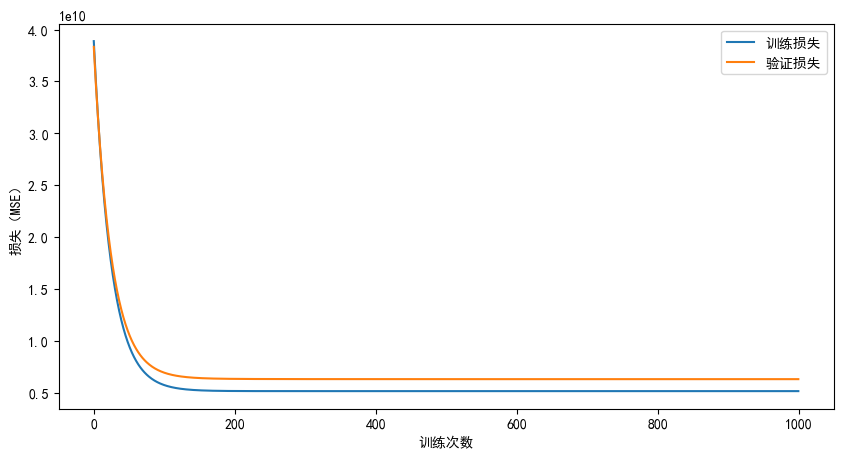

In [27]:
# 设置字体，确保中文正常显示
plt.rcParams["font.family"] = ["SimHei"]
# 解决负号显示问题（可选）
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.xlabel('训练次数')
plt.ylabel('损失（MSE）')
plt.legend()
plt.show()

In [28]:
# 打印权重（w）
print("模型学到的权重w：")
print(model.linear.weight)
# 打印偏置（b）
print("模型学到的偏置b：")
print(model.linear.bias)

模型学到的权重w：
Parameter containing:
tensor([[ 1894.7958, 19911.1914, 13632.5381,  2762.6455,  -247.4401]],
       requires_grad=True)
模型学到的偏置b：
Parameter containing:
tensor([180956.2969], requires_grad=True)
